In [1]:
!pip install pandas numpy tqdm nltk wordcloud matplotlib scikit-learn

In [6]:
# file: ngram_amharic.py
import os
from collections import Counter, defaultdict
import random
import math
from tqdm import tqdm
import nltk
nltk.download('punkt')  # not strictly needed for whitespace tokenization

# Utilities
def read_corpus(path):
    """Reads a plain text corpus file; returns list of sentences (strings)."""
    with open(path, 'r', encoding='utf-8') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    return lines

def simple_tokenize(sentence):
    """Whitespace tokenization. Keep punctuation as tokens if separated by space."""
    return sentence.split()

sentences = read_corpus('GPAC.txt')
tokens_sentences = [simple_tokenize(s) for s in sentences]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#1.1 Create n-grams for n=1,2,3,4 & show sample prints

In [7]:
from collections import Counter

def build_ngrams(tokens_sentences, n):
    """Return Counter of n-grams (tuples) and total n-gram count."""
    counts = Counter()
    for toks in tokens_sentences:
        # Optionally add sentence boundary tokens:
        padded = (['<s>'] * (n-1)) + toks + ['</s>']
        for i in range(len(padded) - n + 1):
            ng = tuple(padded[i:i+n])
            counts[ng] += 1
    return counts

# Usage:
tokens_sentences = [simple_tokenize(s) for s in sentences]
unigrams = build_ngrams(tokens_sentences, 1)
bigrams = build_ngrams(tokens_sentences, 2)
trigrams = build_ngrams(tokens_sentences, 3)
fourgrams = build_ngrams(tokens_sentences, 4)

# Sample prints:
print("Top 10 unigrams:", unigrams.most_common(10))
print("Top 10 bigrams:", bigrams.most_common(10))
print("Top 10 trigrams:", trigrams.most_common(10))
print("Top 10 fourgrams:", fourgrams.most_common(10))

Top 10 unigrams: [(('ላይ',), 3840), (('ነው፡፡',), 3822), (('ነው',), 2623), (('ወደ',), 2176), (('እና',), 2087), (('ግን',), 2038), (('ውስጥ',), 1928), (('ጋር',), 1721), (('ነገር',), 1467), (('አንድ',), 1462)]
Top 10 bigrams: [(('ዓ', 'ም'), 592), (('(', ')'), 505), (('ነገር', 'ግን'), 289), (('ብቻ', 'ሳይሆን'), 215), (('ማለት', 'ነው፡፡'), 158), (('አዲስ', 'አበባ'), 132), (('ምን', 'ያህል'), 131), (('ብቻ', 'ነው፡፡'), 125), (('ኤ', 'አ'), 113), (('ሚሊዮን', 'ዶላር'), 107)]
Top 10 trigrams: [(('እ', 'ኤ', 'አ'), 104), (('2004', 'ዓ', 'ም'), 52), (('በ2003', 'ዓ', 'ም'), 38), (('ቀን', '2004', 'ዓ'), 37), (('2003', 'ዓ', 'ም'), 29), (('ዓ', 'ም', 'ጀምሮ'), 24), (('ነበር፡፡', 'ነገር', 'ግን'), 24), (('በዓለም', 'አቀፍ', 'ደረጃ'), 22), (('(', ')', 'እና'), 21), (('በ2004', 'ዓ', 'ም'), 21)]
Top 10 fourgrams: [(('ቀን', '2004', 'ዓ', 'ም'), 34), (('በብርሃንና', 'ሰላም', 'ማተሚያ', 'ቤት'), 11), (('አዲስ', 'አበባ', 'ስፖርት', 'ማህበር'), 11), (('ጋር', 'ሆኖ', 'ኢህአዴግን', 'ወጋ፣'), 10), (('ቀን', '2003', 'ዓ', 'ም'), 10), (('የአለም', 'የኢኮኖሚ', 'ቀውስና', 'የነዳጅ'), 10), (('እስከ', 'ቅርብ', 'ጊዜ', 'ድረስ'), 9), (('ከዚህ', 'በኋላ', 

#1.2 Calculate probabilities of n-grams and show top 10 most likely n-grams

### Maximum Likelihood Estimation (MLE):

For unigram: P(w) = count(w) / total_unigrams

For bigram: P(w2 | w1) = count(w1,w2) / count(w1)

For 3-gram: P(w3 | w1,w2) = count(w1,w2,w3) / count(w1,w2)

In [8]:
from collections import Counter

# ---------- N-GRAM BUILDER FUNCTION ----------
def build_ngrams(tokens_sentences, n):
    counts = Counter()
    for toks in tokens_sentences:
        padded = (['<s>'] * (n-1)) + toks + ['</s>']
        for i in range(len(padded) - n + 1):
            ngram = tuple(padded[i:i+n])
            counts[ngram] += 1
    return counts


# ---------- PROBABILITY FUNCTIONS ----------
def unigram_probs(unigram_counts):
    total = sum(unigram_counts.values())
    return {ng: count / total for ng, count in unigram_counts.items()}


def conditional_probs(ngram_counts, lower_order_counts):
    cond_p = {}
    for ng, count in ngram_counts.items():
        context = ng[:-1]  # n-1 gram
        context_count = lower_order_counts.get(context, 0)
        if context_count > 0:
            cond_p[ng] = count / context_count
        else:
            cond_p[ng] = 0.0  # unseen context
    return cond_p


# ---------- MAIN TASK 1.2 EXECUTION ----------
# Build n-grams for n = 1..4
unigrams = build_ngrams(tokens_sentences, 1)
bigrams = build_ngrams(tokens_sentences, 2)
trigrams = build_ngrams(tokens_sentences, 3)
fourgrams = build_ngrams(tokens_sentences, 4)

# Compute probabilities
unigram_prob = unigram_probs(unigrams)
bigram_prob = conditional_probs(bigrams, unigrams)
trigram_prob = conditional_probs(trigrams, bigrams)
fourgram_prob = conditional_probs(fourgrams, trigrams)

# Helper to print top-10 by probability
def show_top_ngrams(prob_dict, n=10, title=""):
    print("\n" + title)
    for ng, p in sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{' '.join(ng)}  -->  {p:.6f}")


# ---------- PRINT TOP-10 FOR ALL N-GRAMS ----------
show_top_ngrams(unigram_prob, 10, "Top 10 Most Likely Unigrams:")
show_top_ngrams(bigram_prob, 10, "Top 10 Most Likely Bigrams:")
show_top_ngrams(trigram_prob, 10, "Top 10 Most Likely Trigrams:")
show_top_ngrams(fourgram_prob, 10, "Top 10 Most Likely 4-grams:")


Top 10 Most Likely Unigrams:
ላይ  -->  0.008353
ነው፡፡  -->  0.008314
ነው  -->  0.005706
ወደ  -->  0.004733
እና  -->  0.004540
ግን  -->  0.004433
ውስጥ  -->  0.004194
ጋር  -->  0.003744
ነገር  -->  0.003191
አንድ  -->  0.003180

Top 10 Most Likely Bigrams:
ደርሷት ልትታደመው  -->  1.000000
ልትታደመው ያልቻለችው  -->  1.000000
ለ19ኛ ጊዜ  -->  1.000000
አንጀቷ ባረረ  -->  1.000000
ባረረ ልክ  -->  1.000000
ልትታደም ሁለት  -->  1.000000
ላከች፡፡6ኛው ቢግ  -->  1.000000
በፈታኝ ሁኔታ  -->  1.000000
የሚያስመሰክሩበት መሆኑን  -->  1.000000
የሚገጥሟቸውን የተለያዩ  -->  1.000000

Top 10 Most Likely Trigrams:
<s> ምን መሰላችሁ?  -->  1.000000
መሰላችሁ? (አንባቢያን) ኢትዮጵያ  -->  1.000000
(አንባቢያን) ኢትዮጵያ በተደጋጋሚ  -->  1.000000
ኢትዮጵያ በተደጋጋሚ ጥሪው  -->  1.000000
በተደጋጋሚ ጥሪው ደርሷት  -->  1.000000
ጥሪው ደርሷት ልትታደመው  -->  1.000000
ደርሷት ልትታደመው ያልቻለችው  -->  1.000000
ልትታደመው ያልቻለችው የአለም  -->  1.000000
ያልቻለችው የአለም የእግር  -->  1.000000
የአለም የእግር ኳስ  -->  1.000000

Top 10 Most Likely 4-grams:
<s> <s> ምን መሰላችሁ?  -->  1.000000
<s> ምን መሰላችሁ? (አንባቢያን)  -->  1.000000
ምን መሰላችሁ? (አንባቢያን) ኢትዮጵያ  -->  1.000000

#1.3 Conditional probability of a word given the previous word using bigrams

###We compute P(w2​∣w1​)=count(w1​,w2​)/count(w1​)​ as shown. To query:

In [9]:
# CONDITIONAL PROBABILITY USING BIGRAMS (Task 1.3)

def conditional_prob_bigram(prev_word, next_word, bigram_counts, unigram_counts):
    prev = (prev_word,)
    bigram = (prev_word, next_word)

    prev_count = unigram_counts.get(prev, 0)
    bigram_count = bigram_counts.get(bigram, 0)

    if prev_count == 0:
        return 0.0  # unseen context

    return bigram_count / prev_count


# ---------- Example usage ----------
# Replace the example words below with Amharic words in your corpus
example_prev = "ኢትዮጵያ"
example_next = "ታሪካዊ"

prob = conditional_prob_bigram(example_prev, example_next, bigrams, unigrams)
print(f"P({example_next} | {example_prev}) = {prob:.6f}")

P(ታሪካዊ | ኢትዮጵያ) = 0.003333


In [10]:
def top_next_words(prev_word, bigram_counts, unigram_counts, top_k=10):
    candidates = []

    for (w1, w2), c in bigram_counts.items():
        if w1 == prev_word:
            p = conditional_prob_bigram(w1, w2, bigram_counts, unigram_counts)
            candidates.append((w2, p))

    candidates.sort(key=lambda x: x[1], reverse=True)
    return candidates[:top_k]


# Example:
top_words = top_next_words(example_prev, bigrams, unigrams)
print(f"\nTop likely words after '{example_prev}':")
for w, p in top_words:
    print(f"{example_prev} → {w}   (P={p:.6f})")


Top likely words after 'ኢትዮጵያ':
ኢትዮጵያ → ውስጥ   (P=0.083333)
ኢትዮጵያ → ቡና   (P=0.026667)
ኢትዮጵያ → በዋጋ   (P=0.016667)
ኢትዮጵያ → ግን   (P=0.010000)
ኢትዮጵያ → ጠግባ   (P=0.010000)
ኢትዮጵያ → መጥተው   (P=0.010000)
ኢትዮጵያ → ፊልም   (P=0.010000)
ኢትዮጵያ → የፊልም   (P=0.010000)
ኢትዮጵያ → የምትባል   (P=0.010000)
ኢትዮጵያ → ቢዝነስ   (P=0.010000)


#1.4 Remove common stopwords and recompute frequencies (top 10 n-grams)

In [11]:
amharic_stopwords = {
"እኔ","እሱ","እሷ","እኛ","እናንተ","እነሱ","የ","ለ","በ","ከ","ስለ","እንዲህ","እንዲሁ","የሚችል","ከላይ","እንደገና","በመላ","መቃወም","አይደለም","የሚፈቅደው","መካከል","አንድ","እና","ሌላ","ማንም","ሰው","በማንኛውም","መንገድ","ማንኛውም","በየትኛውም","ቦታ","ለየት","ይታይ","አመስግኑት","ተገቢ","ዙሪያ","እንደ","ጎን","ጠይቅ","መጠየቅ","ተያይዟል","ይገኛል","ራቅ","አስፈሪ","ሆነ","መሆን","በፊት","ከኋላ","ሁለቱም","አጭር","ግን","እንበል","መጣ","አይችልም","ምክንያት","በእርግጠኝነት","ማጤን","የያዘ","ይይዛል","የሚዛመደው","ኮርስ","አሁን","መ","ይገለጻል","ቢሆንም","አልተደረገም","አልሆነም","የተለየ","አደረገ","አያደርግም","ወደታች","በጊዜው","እያንዳንዱ","ኢዱ","ለምሳሌ","ስምንት","ወይ","በቃ","ምሳሌ","በስተቀር","ሩቅ","ጥቂት","አምስተኛ","መጀመሪያ","አምስት","የተከተለ","መከተል","የሚከተለው","የቀድሞ","የሰጠ","ሂድ","ይሄዳል","ሄዷል","አግኝቷል","አደረሳችሁ","ሰላምታ","ሸ","ነበር","ይከሰታል","በጭንቅ","አለው","የሌለው","የነበረው","ያለው","ሄሎ","እገዛ","ስለዚህ","እሷን","እዚህ","በተስፋ","እንዴት","ይሁን","እንጂ","ከሆነ","ተናቆት","ወዲያው","ይልቅ","ወደ","ይሆናል","እራሱ","አቆይ","ይጠብቃል","አወቅ","የሚታወቅ","ያውቃል","የመጨረሻው","በቅርቡ","በኋላ","የኋለኛው","እንዳንል","እንወድ","ይመስላል","በዋነኛነት","ብዙ","ይችላል","ምናልባት","ማለት","ነው","ይህ","በእንዲህ","እንዳለ","ብቻ","ተጨማሪ","ከዚህ","በላይ","በቅርብ","አስፈላጊ","ፍላጎት","አዲስ","ያልሆነ","የለም","ጠፍቷል","ብዙውን","ጊዜ","ኦህ","እሺ","አሮጌው","ላይ","ወይም","ሌሎች","ካለበለዚያ","የእኛ","በተለይ","ምናልባትም","የተቀመጠ","እባክዎ","ፕላስ","ይቻላል","የሚገመተው","ይሰጣል","በአንጻራዊነት","በቅደም","ተከተል","ትክክል","ስ","ተብሏል","ተመሳሳይ","አየው","ይላል","ሲል","ሁለተኛ","ማየት","የሚመስል","የታየ","እራስ","የላከ","ቁምነገር","ሰባት","በርካታ","ይኖሯታል","አለባት","ጀምሮ","ነገር","አንዳንድ","ይቅርታ","የተገለጸ","ይግለጹ","የሚገልጽ","አሁንም","ንኡስ","እርግጠኛ","ተወስዷል","አመሰግናለሁ","ተመስገን","ናቸው","አስበዋል","መሞከር","ሁለት","ስር","በሚያሳዝን","ሁኔታ","ካልሆነ","በስተቀር","ጥቅም","የዋለ","ጠቃሚ","ይጠቀማል","ይፈልጋል","ነበር","እንሆናለን","እንኳን","ደህና","መጣችሁ","መቼ","የትኛው","እያለ","ወዴት","ሙሉ","ማን","የማን","ለምን","ይፈቅዳል","የሚፈልግ","የሚመኝ","አይገርምም","ታደርጋለህ","አንተ","ነህ","የራስህ","ራስህ","ዜሮ"
}

# ------------------- Stopword Removal -------------------
def remove_stopwords_tokens(tokens_sentences, stopwords):
    filtered = []
    for toks in tokens_sentences:
        new_toks = [w for w in toks if w not in stopwords]
        if new_toks:
            filtered.append(new_toks)
    return filtered


# Remove stopwords
tokens_no_stop = remove_stopwords_tokens(tokens_sentences, amharic_stopwords)


# ------------------- Rebuild N-Grams Without Stopwords -------------------
def build_ngrams(tokens_sentences, n):
    counts = Counter()
    for toks in tokens_sentences:
        padded = (['<s>'] * (n-1)) + toks + ['</s>']
        for i in range(len(padded) - n + 1):
            ngram = tuple(padded[i:i+n])
            counts[ngram] += 1
    return counts

unigrams_ns = build_ngrams(tokens_no_stop, 1)
bigrams_ns = build_ngrams(tokens_no_stop, 2)
trigrams_ns = build_ngrams(tokens_no_stop, 3)
fourgrams_ns = build_ngrams(tokens_no_stop, 4)


# ------------------- Print Top 10 N-Grams -------------------
def show_top(counts, title):
    print("\n" + title)
    for ng, c in counts.most_common(10):
        print(f"{' '.join(ng)}  -->  {c}")

show_top(unigrams_ns,  "Top 10 Unigrams (No Stopwords):")
show_top(bigrams_ns,   "Top 10 Bigrams (No Stopwords):")
show_top(trigrams_ns,  "Top 10 Trigrams (No Stopwords):")
show_top(fourgrams_ns, "Top 10 4-grams (No Stopwords):")


Top 10 Unigrams (No Stopwords):
ነው፡፡  -->  3822
ውስጥ  -->  1928
ጋር  -->  1721
ነበር፡፡  -->  1458
ደግሞ  -->  1238
ምን  -->  995
ሁሉ  -->  926
ብሎ  -->  737
ቤት  -->  736
ዓመት  -->  704

Top 10 Bigrams (No Stopwords):
ዓ ም  -->  592
( )  -->  507
ምን ያህል  -->  131
ኤ አ  -->  113
ሚሊዮን ዶላር  -->  107
እ ኤ  -->  105
የሰው ልጅ  -->  96
እግር ኳስ  -->  82
አቶ በረከት  -->  82
በአዲስ አበባ  -->  81

Top 10 Trigrams (No Stopwords):
እ ኤ አ  -->  104
2004 ዓ ም  -->  52
በ2003 ዓ ም  -->  38
ቀን 2004 ዓ  -->  37
2003 ዓ ም  -->  29
በዓለም አቀፍ ደረጃ  -->  22
በ2004 ዓ ም  -->  21
ጤና ጥበቃ ሚኒስር  -->  20
የሁለት ምርጫዎች ወግ  -->  19
የኒውክሊየር ጦር መሣሪያ  -->  18

Top 10 4-grams (No Stopwords):
ቀን 2004 ዓ ም  -->  34
በብርሃንና ሰላም ማተሚያ ቤት  -->  11
ጋር ሆኖ ኢህአዴግን ወጋ፣  -->  10
ቀን 2003 ዓ ም  -->  10
የአለም የኢኮኖሚ ቀውስና የነዳጅ  -->  10
በኢፊድሪ ጤና ጥበቃ ሚኒስር  -->  9
ከፖለቲካ ያገኛቸው ክብር፣ ተሰሚነት፣  -->  8
በ2004 ዓ ም ኢትዮጵያ  -->  8
ጤና ጥበቃ ሚኒስር የእናቶች  -->  8
ጥበቃ ሚኒስር የእናቶች ጤና  -->  8


#1.5 Create word clouds for unigrams, bigrams, trigrams before and after stopword removal

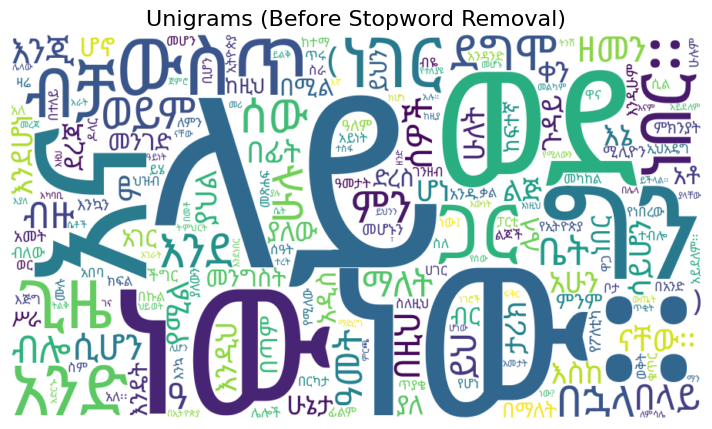

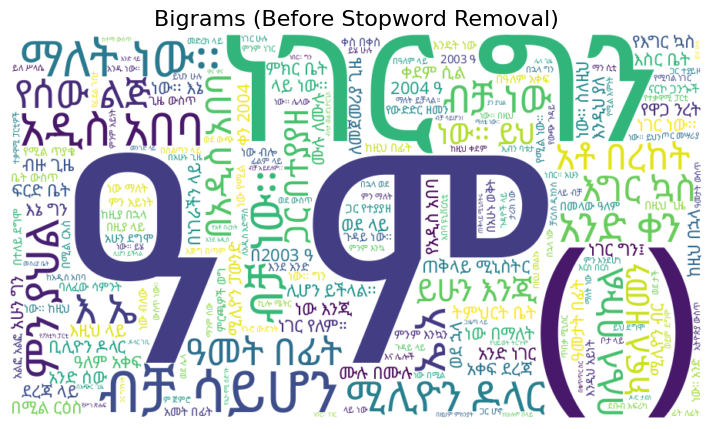

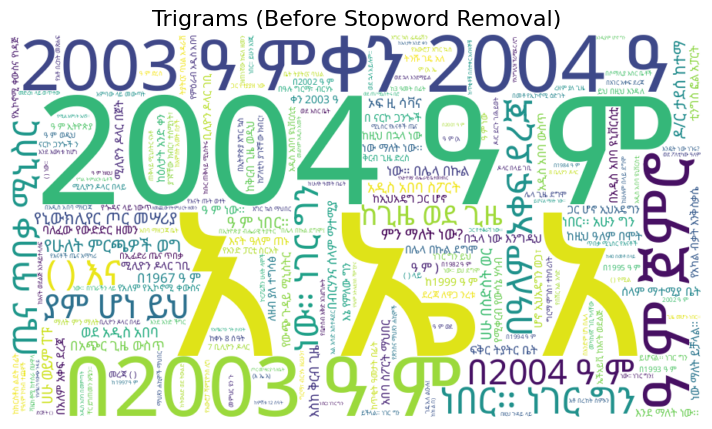

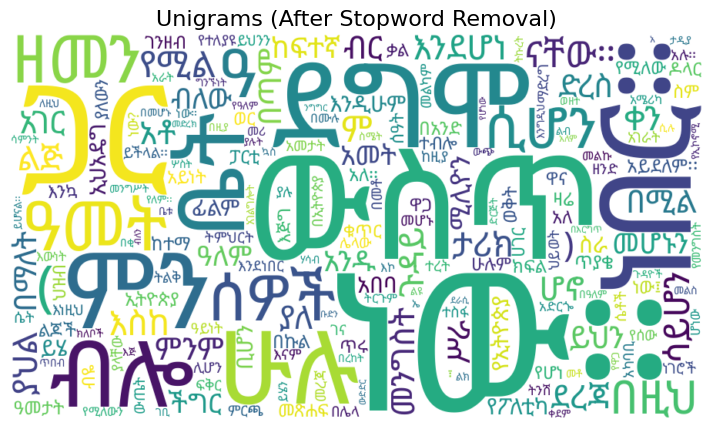

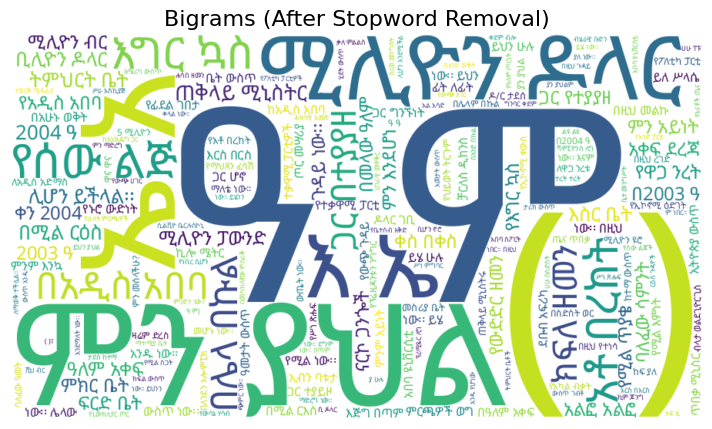

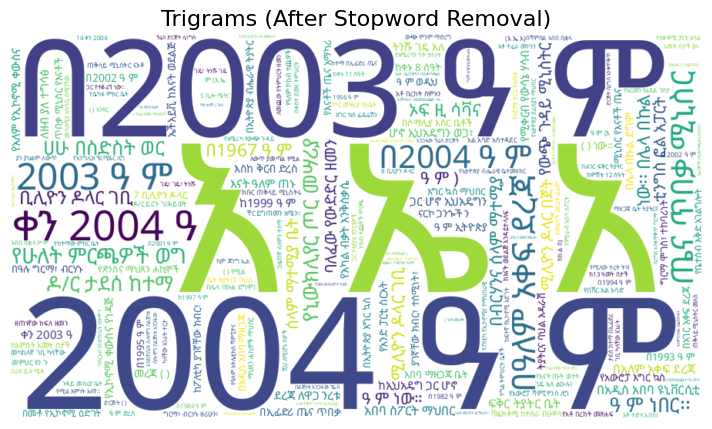

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to convert n-gram Counter to frequency dict for wordcloud
def ngram_freq_dict(ngram_counts):
    freq = {}
    for ng, count in ngram_counts.items():
        text = " ".join(ng)  # Convert tuple to string
        freq[text] = count
    return freq


def show_wordcloud(freq_dict, title, font_path):
    wc = WordCloud(
        font_path=font_path,
        width=900,
        height=500,
        background_color="white"
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


# Path to Amharic font
font_path = "NotoSansEthiopic.ttf"  # Change if needed


# BEFORE STOPWORD REMOVAL
show_wordcloud(ngram_freq_dict(unigrams), "Unigrams (Before Stopword Removal)", font_path)
show_wordcloud(ngram_freq_dict(bigrams), "Bigrams (Before Stopword Removal)", font_path)
show_wordcloud(ngram_freq_dict(trigrams), "Trigrams (Before Stopword Removal)", font_path)

# AFTER STOPWORD REMOVAL
show_wordcloud(ngram_freq_dict(unigrams_ns), "Unigrams (After Stopword Removal)", font_path)
show_wordcloud(ngram_freq_dict(bigrams_ns), "Bigrams (After Stopword Removal)", font_path)
show_wordcloud(ngram_freq_dict(trigrams_ns), "Trigrams (After Stopword Removal)", font_path)


#1.6 Probability of the sentence "ኢትዮጵያ ታሪካዊ ሀገር ናት"

We compute sentence probability using the n-gram chain rule with smoothing. For bigram MLE:

P(sentence) = P(w1|<s>) * P(w2|w1) * P(w3|w2) * ... * P(</s>|wn)

Use log probabilities to avoid underflow.

In [26]:
import math

# --------- Sentence probability using Bigram Model ---------
def sentence_probability(sentence_tokens, bigram_counts, unigram_counts, smoothing=1):
    """
    smoothing = 0 → MLE
    smoothing = 1 → Laplace smoothing
    """
    V = len(unigram_counts)  # vocabulary size

    sent = ["<s>"] + sentence_tokens + ["</s>"]
    log_prob = 0.0  # use log probabilities to avoid underflow

    for i in range(1, len(sent)):
        prev = sent[i - 1]
        curr = sent[i]

        bigram = (prev, curr)
        unigram = (prev,)

        bigram_count = bigram_counts.get(bigram, 0)
        unigram_count = unigram_counts.get(unigram, 0)

        if smoothing == 0:
            # MLE (no smoothing)
            if unigram_count == 0 or bigram_count == 0:
                return 0.0  # probability = 0
            p = bigram_count / unigram_count
        else:
            # Laplace smoothing
            p = (bigram_count + 1) / (unigram_count + V)

        log_prob += math.log(p)

    return math.exp(log_prob), log_prob  # return normal + log probability


# --------- Example computation for the required sentence ---------
sentence = "ኢትዮጵያ ታሪካዊ ሀገር ናት"
sentence_tokens = sentence.split()

prob, log_prob = sentence_probability(sentence_tokens, bigrams, unigrams, smoothing=1)

print("Sentence:", sentence)
print("Probability:", prob)
print("Log Probability:", log_prob)

Sentence: ኢትዮጵያ ታሪካዊ ሀገር ናት
Probability: 9.665242583811702e-26
Log Probability: -57.59867620629535


#1.7 Generate random sentences using n-grams; explain what happens as n increases

Sampling from an n-gram model:

In [27]:
import random
from collections import defaultdict

# -------------- Helper: Convert n-gram counts into context → next-word map --------------
def build_context_map(ngram_counts, n):
    context_map = defaultdict(list)
    for ng, count in ngram_counts.items():
        context = ng[:-1]     # previous n-1 tokens
        next_word = ng[-1]
        context_map[context].append((next_word, count))
    return context_map


# -------------- Sentence generator --------------
def generate_sentence(n, ngram_counts, max_len=25):
    # Unigram model (n = 1)
    if n == 1:
        words, freqs = zip(*[(w[0], count) for w, count in ngram_counts.items()])
        total = sum(freqs)
        probs = [c / total for c in freqs]

        sentence = []
        for _ in range(max_len):
            w = random.choices(words, weights=probs)[0]
            if w == "</s>":
                break
            sentence.append(w)
        return " ".join(sentence)

    # N > 1: Bigram, Trigram, Fourgram
    context_map = build_context_map(ngram_counts, n)

    # Initial context: <s> tokens
    context = tuple(["<s>"] * (n - 1))
    sentence = []

    for _ in range(max_len):
        if context not in context_map:
            break

        options, weights = zip(*context_map[context])
        next_word = random.choices(options, weights=weights)[0]

        if next_word == "</s>":
            break

        sentence.append(next_word)

        # Update context
        context = tuple(list(context[1:]) + [next_word])

    return " ".join(sentence)


# ----------------- Generate example sentences -----------------
print("Unigram Sentence:\n", generate_sentence(1, unigrams))
print("\nBigram Sentence:\n", generate_sentence(2, bigrams))
print("\nTrigram Sentence:\n", generate_sentence(3, trigrams))
print("\nFourgram Sentence:\n", generate_sentence(4, fourgrams))

Unigram Sentence:
 ነው፡፡ መሳሪያዎቹን ጦሩ እንደታየው ሴታ ባርሴሎናም ምርጫ ጠርቶ ስለዚህ ፀሐፊዎችና ጫፍ (ለእኔ ሜዳ ላይ ነበር ሲፈፅሙ ስታስገባም ለማዘጋጀት እየተለመደ ጥራት እሱ እንጂ ለእኔ ኳስ ነው

Bigram Sentence:
 ምን ብለውህ ነው? ብሎ በስውር ሳይሆን የተስፋ ሀ ሁ ስለመሰለኝ (ጻፍኩት) ሀሁ ያልገባቸው ሰዎች ቤት የእግዚአብሔር ዘለአለማዊ ትንፋሽ እየከለከለ ተመልካችን ጭምር ብልጭልጭ ነገሮችን ለመቀጠል ኢህአዴግ

Trigram Sentence:
 ምን መሰላችሁ? በጥንቃቄ የመስራት አቅሙ እየሞተ እንደሚሄድ አያጠራጥርም። የፓርቲዎች ጠንካራ ፉክክር አለመኖሩኮ፤ እዚህ ላይ ነው፤ ያ ደግሞ በጥድፊያ የሚሰራ ሳይሆን ጥናትና ማጤን የሚጠይቅ ሊሆን ይችላል፡፡

Fourgram Sentence:
 ምን መሰላችሁ? (አንባቢያን) ኢትዮጵያ በተደጋጋሚ ጥሪው ደርሷት ልትታደመው ያልቻለችው የአለም የእግር ኳስ ዋ ለ19ኛ ጊዜ በደቡብ አፍሪካ ሲጠጣ፣ በሩቅ እያየች አንጀቷ ባረረ ልክ በአመቱ በለስ


## Explanation (what happens as n increases):

* Unigram (n=1): Random words, often ungrammatical; captures only word frequencies.

* Bigram (n=2): Local coherence — some grammatical pairs appear; still limited context.

* Trigram/fourgram: More fluent sequences and more realistic sentences but require much more data — risk of producing exact training phrases and failing on unseen contexts. Higher n reduces diversity unless corpus is large; also needs smoothing to handle unseen n-grams.

#Intrinsic evaluation

##Two common intrinsic metrics:

* Perplexity on a held-out test set (lower is better).

* Cross-entropy / log-likelihood.

Compute perplexity using the bigram or trigram model with smoothing.

In [17]:
import random

random.shuffle(sentences)

split = int(0.9 * len(sentences))
train_sentences = sentences[:split]
test_sentences = sentences[split:]

train_tokens = [s.split() for s in train_sentences]
test_tokens  = [s.split() for s in test_sentences]

In [18]:
# Rebuild n-grams for correct evaluation
unigrams = build_ngrams(train_tokens, 1)
bigrams  = build_ngrams(train_tokens, 2)
trigrams = build_ngrams(train_tokens, 3)

In [19]:
import math

def perplexity(test_data, ngram_counts, lower_counts, n, smoothing=1):
    V = len(unigrams)  # vocabulary size
    total_log_prob = 0
    total_words = 0

    for sentence in test_data:
        sent = ["<s>"]*(n-1) + sentence + ["</s>"]

        for i in range(n-1, len(sent)):
            ngram = tuple(sent[i-n+1:i+1])
            context = ngram[:-1]
            target = ngram[-1]

            num = ngram_counts.get(ngram, 0)
            denom = lower_counts.get(context, 0)

            if smoothing == 1:
                num += 1
                denom += V

            # Avoid math domain errors
            p = num / denom if denom > 0 else 1 / V

            total_log_prob += -math.log(p)
            total_words += 1

    return math.exp(total_log_prob / total_words)

In [21]:
# Re-do train/test split and n-gram building to ensure non-empty training set
# This is necessary because previous splits might have resulted in empty training data
# if the corpus was very small (e.g., only one sentence).

# Assuming 'sentences' variable (from read_corpus('GPAC.txt')) is available and up-to-date.
# If sentences is too small, ensure train_tokens is not empty.
import random # Ensure random is imported for shuffle

if len(sentences) <= 1:
    # If the corpus has 1 or 0 sentences, use it entirely for both training and testing
    # This is a pragmatic solution to avoid an empty training set for very small corpora.
    train_sentences = sentences
    test_sentences = sentences
else:
    # Use the existing split logic if there's enough data
    random.shuffle(sentences) # Shuffle to get a random split
    split = int(0.9 * len(sentences))
    train_sentences = sentences[:split]
    test_sentences = sentences[split:]

# Ensure simple_tokenize is accessible (defined in a previous cell)
# Ensure build_ngrams is accessible (defined in previous cells)
train_tokens = [simple_tokenize(s) for s in train_sentences]
test_tokens  = [simple_tokenize(s) for s in test_sentences]

# Rebuild n-grams based on the (now guaranteed non-empty) train_tokens
unigrams = build_ngrams(train_tokens, 1)
bigrams  = build_ngrams(train_tokens, 2)
trigrams = build_ngrams(train_tokens, 3)

# Check if unigrams is still empty (should not be with the above logic if sentences was not empty)
if not unigrams:
    print("Error: Training unigrams are empty. Perplexity cannot be computed with an empty vocabulary.")
    uni_pp = float('inf')
    big_pp = float('inf')
    trigram_pp = float('inf')
else:
    # The perplexity function requires `unigrams` for V. The function in `atGaBhQnRZaU`
    # uses `len(unigrams)` which should now be > 0.

    # Unigram: P(w)
    # The perplexity function's `lower_counts` for unigram (n=1) needs the total count of words.
    # The context for unigram is an empty tuple `()`.
    total_unigram_counts = sum(unigrams.values())
    uni_lower_counts = {(): total_unigram_counts}

    uni_pp = perplexity(test_tokens, unigrams, uni_lower_counts, 1)

    # Bigram: P(w_i | w_{i-1})
    # For unigrams as lower-order counts, convert (word,) → count
    unigram_map = { (w,): c for (w,), c in unigrams.items() }
    big_pp = perplexity(test_tokens, bigrams, unigram_map, 2)

    # Trigram: P(w_i | w_{i-2}, w_{i-1})
    # Lower-order is bigram counts
    trigram_pp = perplexity(test_tokens, trigrams, bigrams, 3)

print("Unigram Perplexity:", uni_pp)
print("Bigram Perplexity:", big_pp)
print("Trigram Perplexity:", trigram_pp)


Unigram Perplexity: 21707.474213367866
Bigram Perplexity: 43323.641223204
Trigram Perplexity: 52421.03513530165


#Extrinsic evaluation

Pick an extrinsic downstream task; easiest and relevant: next-word prediction (held-out accuracy), or you can use language modelling->text classification if labeled data available. We'll implement next-word prediction accuracy:

* For each test sentence, for each context (w_{i-1}) predict the top-1 word from bigram model and check if it matches the true next word.

* Compute accuracy and top-k accuracy (top-3, top-5).

In [22]:
def top_k_predictions(context, ngram_counts, k=3):
    """
    context: tuple of previous words (n-1 words)
    ngram_counts: bigram or trigram dictionary
    """
    candidates = []

    for ng, count in ngram_counts.items():
        if ng[:-1] == context:     # matches context
            next_word = ng[-1]
            candidates.append((next_word, count))

    # Sort highest count → highest probability
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Return only words
    return [w for w, c in candidates[:k]]

In [23]:
def next_word_accuracy_bigram(test_tokens, bigrams, k=1):
    correct = 0
    total = 0

    for sentence in test_tokens:
        sent = ["<s>"] + sentence + ["</s>"]

        for i in range(1, len(sent)):
            prev_word = sent[i-1]
            true_next = sent[i]

            predictions = top_k_predictions((prev_word,), bigrams, k)

            if true_next in predictions:
                correct += 1

            total += 1

    return correct / total

In [24]:
def next_word_accuracy_trigram(test_tokens, trigrams, k=1):
    correct = 0
    total = 0

    for sentence in test_tokens:
        sent = ["<s>", "<s>"] + sentence + ["</s>"]

        for i in range(2, len(sent)):
            context = (sent[i-2], sent[i-1])
            true_next = sent[i]

            predictions = top_k_predictions(context, trigrams, k)

            if true_next in predictions:
                correct += 1

            total += 1

    return correct / total

In [ ]:
print("=== BIGRAM MODEL ACCURACY ===")
print("Top-1 Accuracy:", next_word_accuracy_bigram(test_tokens, bigrams, k=1))
print("Top-3 Accuracy:", next_word_accuracy_bigram(test_tokens, bigrams, k=3))
print("Top-5 Accuracy:", next_word_accuracy_bigram(test_tokens, bigrams, k=5))

print("\n=== TRIGRAM MODEL ACCURACY ===")
print("Top-1 Accuracy:", next_word_accuracy_trigram(test_tokens, trigrams, k=1))
print("Top-3 Accuracy:", next_word_accuracy_trigram(test_tokens, trigrams, k=3))
print("Top-5 Accuracy:", next_word_accuracy_trigram(test_tokens, trigrams, k=5))

=== BIGRAM MODEL ACCURACY ===
